In [2]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams

%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from proj_acquire import *
from proj_prepare import *

import zgulde.extend_pandas as ep

In [3]:
df = prepare_fitbit()

In [4]:
# set date to index
df.set_index('index', inplace=True)

# dropping columns with mostly zero information
to_drop = ['calories', 'carbs', 'fat', 'fiber',
       'protien', 'sodium', 'water']
df = df.drop(columns=(to_drop))

# remove commas and convert to float64
for col in df:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].astype('float64')

# drop NaN rows as we'll be predicting them anyway
df.dropna(inplace=True)

In [6]:
for col in df:
    print(f'{col} outliers:{df[col].outliers().sum()}')

activity_calories outliers:3
distance outliers:1
floors outliers:12
mins_active_high outliers:0
mins_active_light outliers:17
mins_active_med outliers:11
mins_sedentary outliers:22
steps outliers:1
total_calories outliers:4


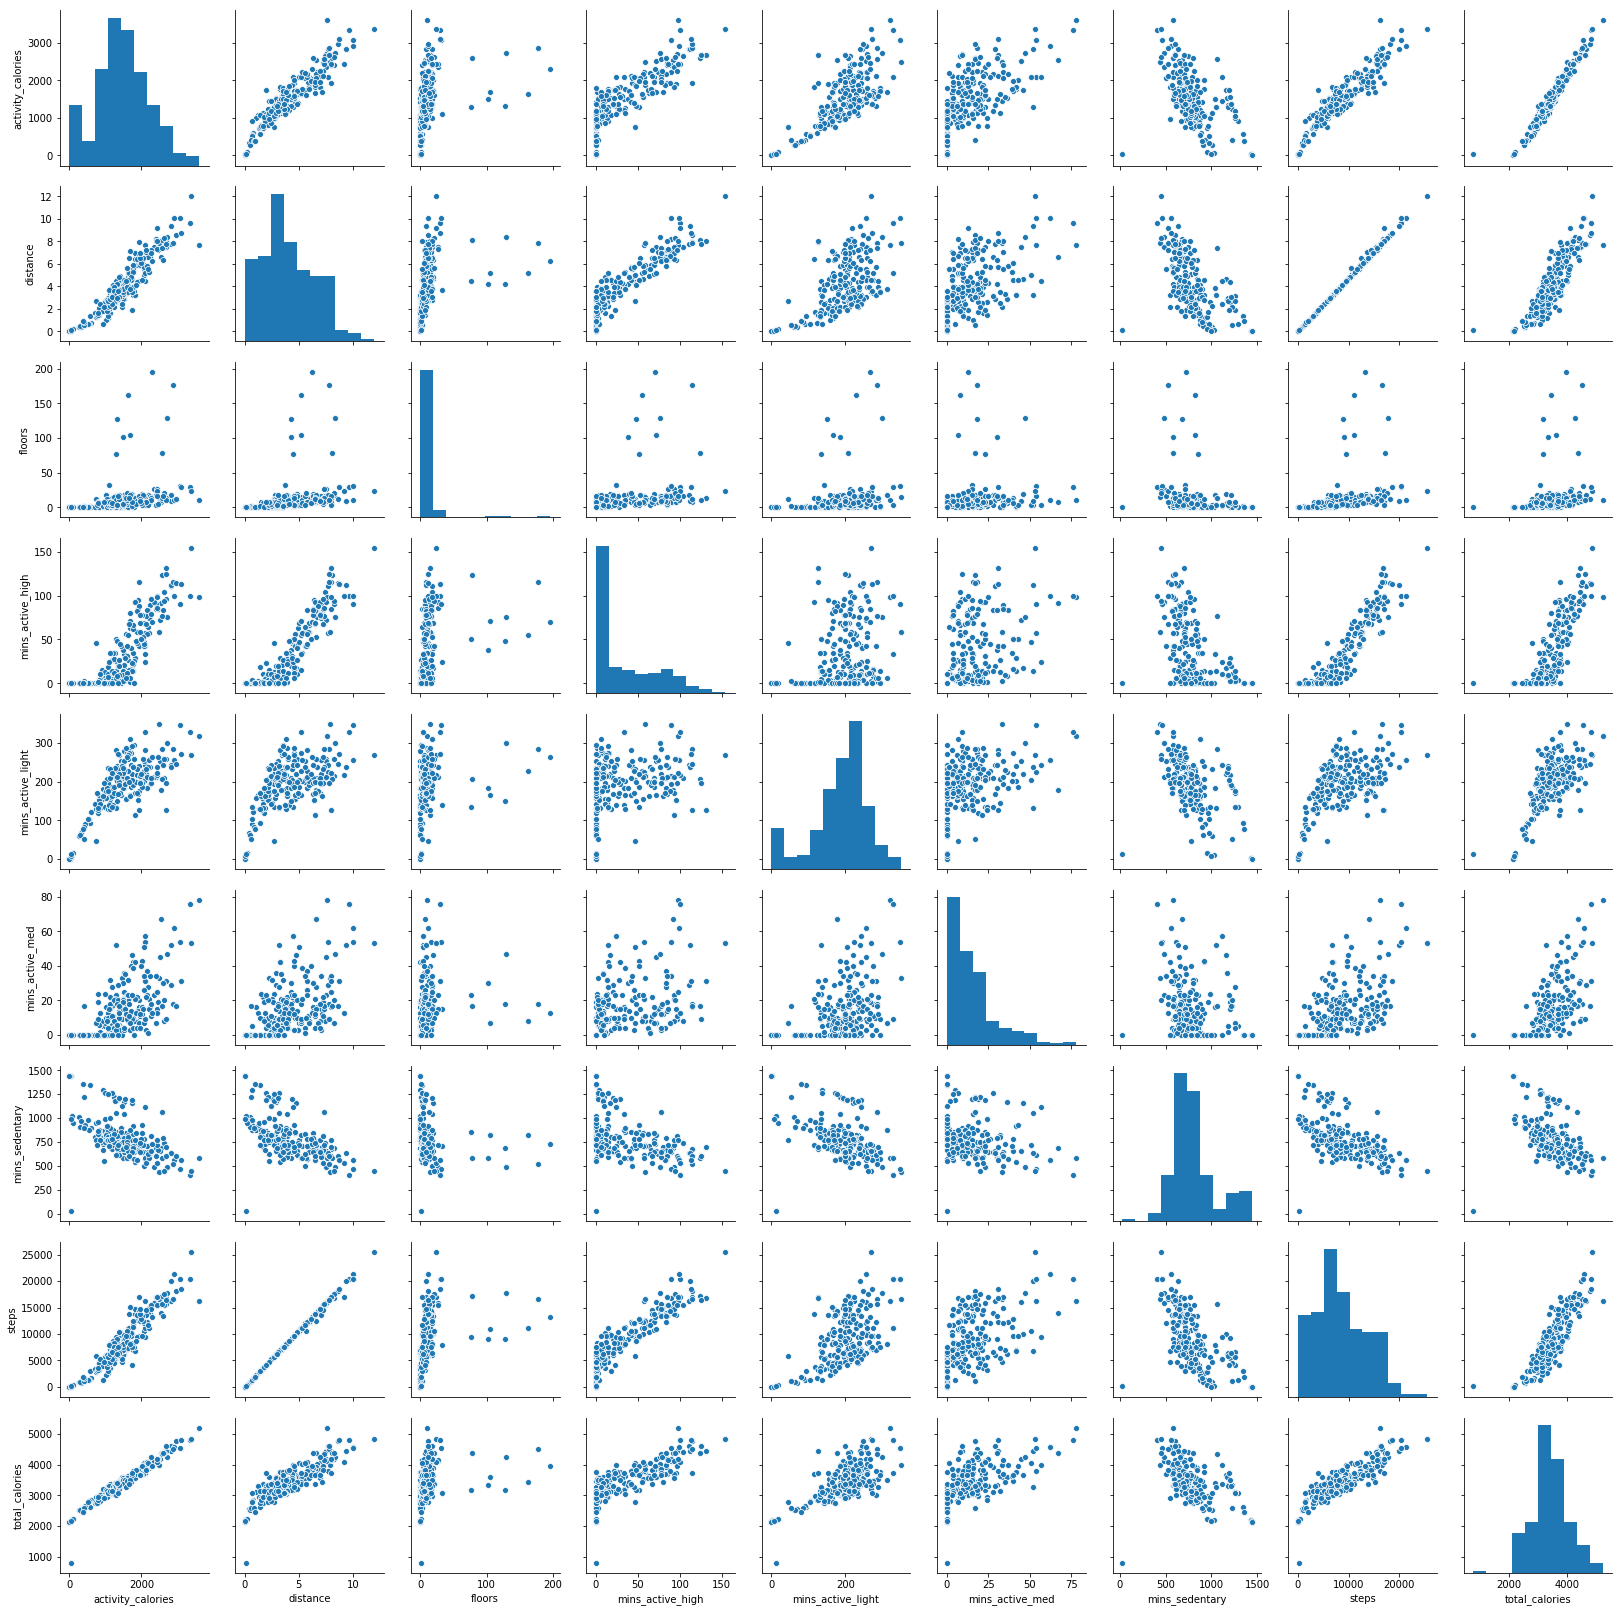

In [7]:
sns.pairplot(df)

<module 'matplotlib.pyplot' from '/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

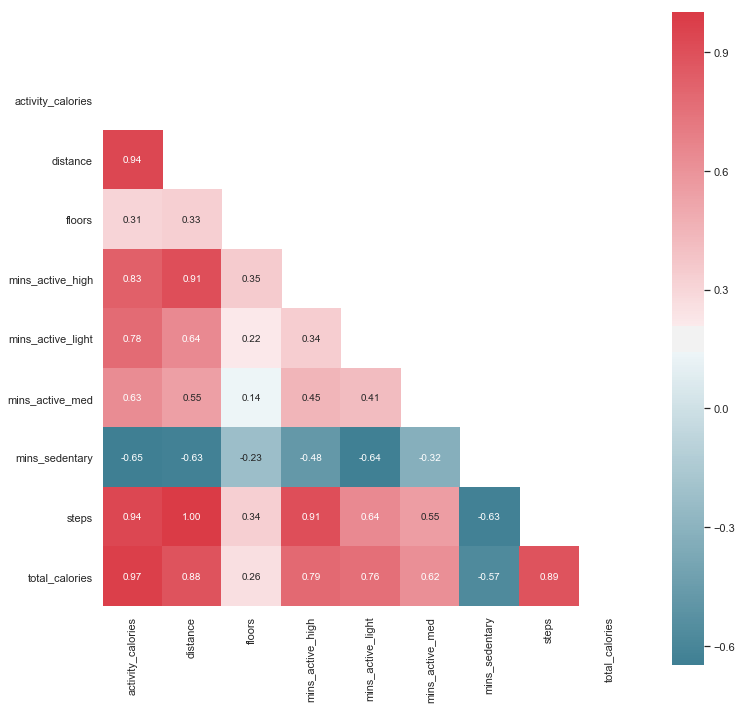

In [8]:
df.correlation_heatmap(fancy=True)

In [11]:
!pwd

/Users/sandragraham/desktop/TimeSeriesProject


In [ ]:
def peekatdata(df):
    '''gives cursory sample of dataframe passed'''
    head_df = df.head(5)
    print(head_df)
    tail_df = df.tail(5)
    print(tail_df)
    shape_tuple = df.shape
    print(shape_tuple)
    describe_df = df.describe()
    print(describe_df)
    df.info()

In [12]:
train = df['2018-04':'2018-09']
test = df['2018-10':'2018-12']
print(train.nunique())
print(test.nunique())

activity_calories    145
distance             130
floors                25
mins_active_high      60
mins_active_light    108
mins_active_med       46
mins_sedentary       131
steps                146
total_calories       145
dtype: int64
activity_calories    65
distance             63
floors               31
mins_active_high     50
mins_active_light    53
mins_active_med      32
mins_sedentary       61
steps                67
total_calories       67
dtype: int64


# Exploration

### mean total calories by day

Text(0.5, 0, 'day')

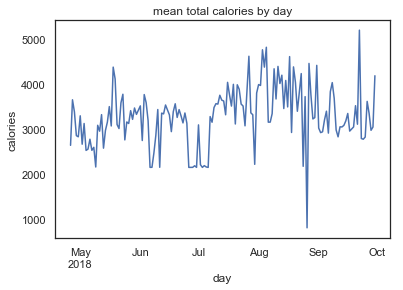

In [15]:
t_cal = train.resample('D').total_calories.mean()
t_cal.plot()
plt.title('mean total calories by day')
plt.ylabel('calories')
plt.xlabel('day')

### mean total calories by week

Text(0.5, 0, 'weeks')

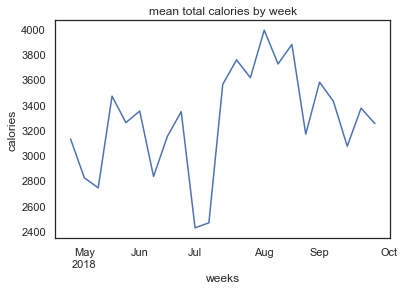

In [16]:
t_cal.resample('W').mean().plot()
plt.title('mean total calories by week')
plt.ylabel('calories')
plt.xlabel('weeks')

### mean total calories by month

Text(0.5, 0, 'month')

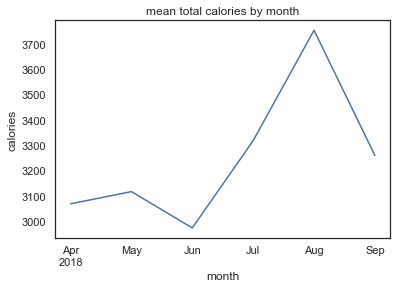

In [32]:
t_cal.resample('M').mean().plot()
plt.title('mean total calories by month')
plt.ylabel('calories')
plt.xlabel('month')

### 5 period rolling mean and plot

In [33]:
t_cal.head(10)

index
2018-04-26    2635.0
2018-04-27    3649.0
2018-04-28    3379.0
2018-04-29    2851.0
2018-04-30    2825.0
2018-05-01    3292.0
2018-05-02    2660.0
2018-05-03    3121.0
2018-05-04    2522.0
2018-05-05    2551.0
Freq: D, Name: total_calories, dtype: float64

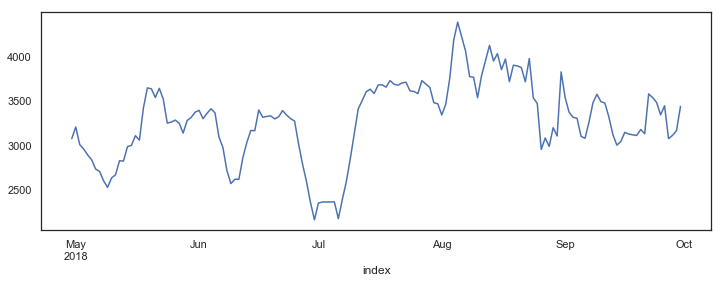

In [28]:
t_cal.rolling(5).mean().plot(figsize=(12, 4))

### 10 period rolling mean and plot

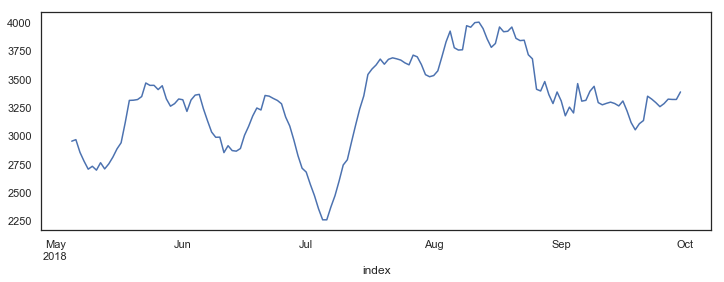

In [29]:
t_cal.rolling(10).mean().plot(figsize=(12, 4))

### Time-series decomposition - trend, seasonality, and noise

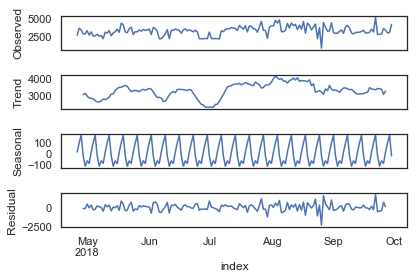

In [30]:
decomposition = sm.tsa.seasonal_decompose(t_cal, model='additive')
fig = decomposition.plot()
plt.show()

### lag plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


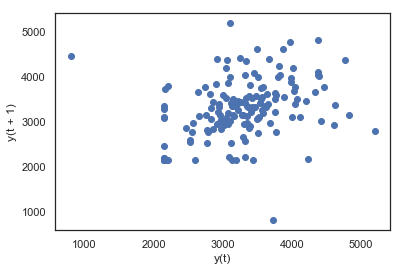

In [31]:
pd.plotting.lag_plot(t_cal)

### pearson's correlation coef

In [34]:
df_corr = pd.concat([t_cal.shift(1), t_cal], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.317357
t+1  0.317357  1.000000


# Modeling

In [35]:
agg1 = 'mean'
agg2 = 'sum'

In [42]:
ts_data1 = df.total_calories.resample('W').agg(agg1)
ts_data2 = df.total_calories.resample('W').agg(agg2)

In [43]:
train_size1 = int(len(ts_data1) * 0.66)
train_1, test_1 = ts_data1[0:train_size1], ts_data1[train_size1:len(ts_data1)]
print('Observations: %d' % (len(ts_data1)))
print('Training Observations: %d' % (len(train_1)))
print('Testing Observations: %d' % (len(test_1)))

train_size2 = int(len(ts_data2) * 0.66)
train_2, test_2 = ts_data2[0:train_size2], ts_data2[train_size2:len(ts_data2)]
print('Observations: %d ' % (len(ts_data2)))
print('Training Observations: %d' % (len(train_2)))
print('Testing Observations: %d' % (len(test_2)))

Observations: 33
Training Observations: 21
Testing Observations: 12
Observations: 33 
Training Observations: 21
Testing Observations: 12


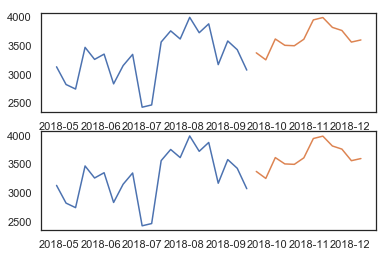

In [44]:
plt.subplot(211)
plt.plot(train_1)
plt.plot(test_1)

plt.subplot(212)
plt.plot(train_1)
plt.plot(test_1)

plt.show()

### Simple Average

In [46]:
train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 158
Testing Observations: 67


In [48]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat['diff'] = yhat['actual'] - yhat['avg_forecast']
yhat.head()

,actual,avg_forecast,diff
index,,,
2018-10-01,3180.0,3278.968354,-98.968354
2018-10-02,3162.0,3278.968354,-116.968354
2018-10-03,3584.0,3278.968354,305.031646
2018-10-04,3713.0,3278.968354,434.031646
2018-10-05,3603.0,3278.968354,324.031646


In [49]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

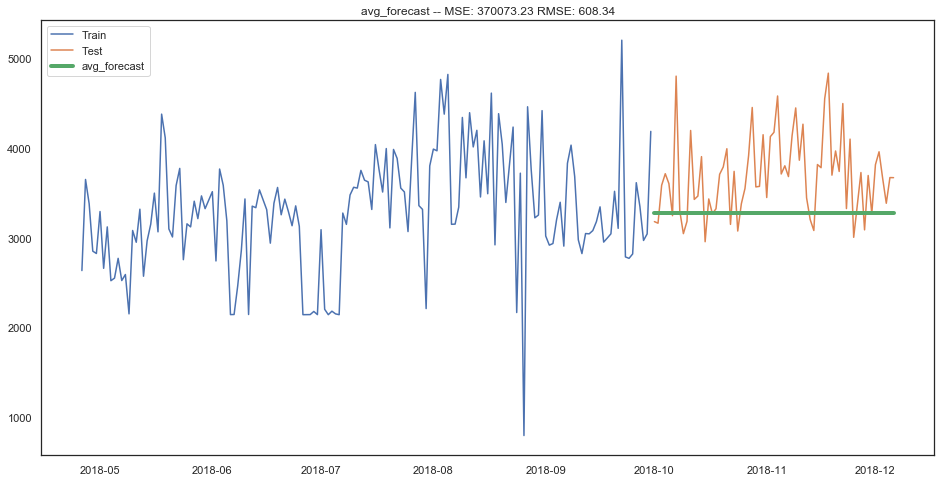

In [50]:
plot_and_eval(yhat.avg_forecast)

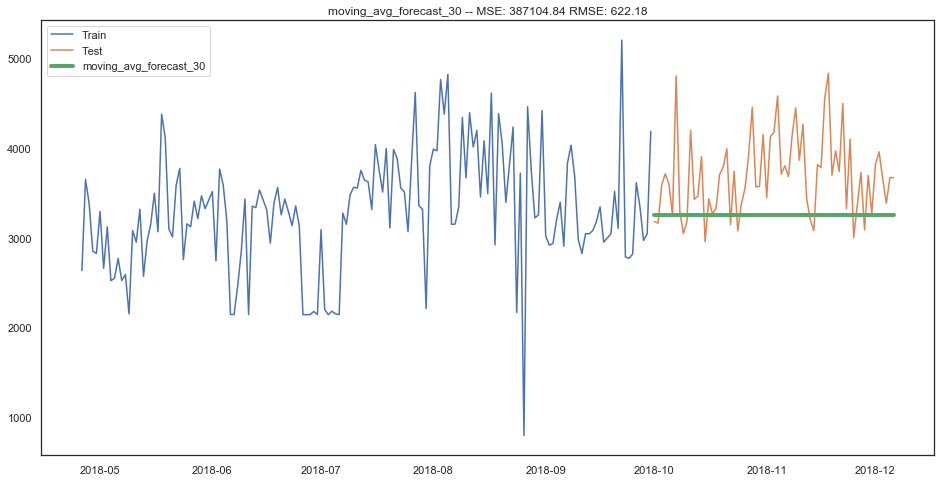

In [51]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_30)

In [66]:
yhat.head()

,actual,avg_forecast,diff,moving_avg_forecast_30,moving_avg_forecast_1,moving_avg_forecast_4,moving_avg_forecast_12,moving_avg_forecast_26
index,,,,,,,,
2018-10-01,3180.0,3278.968354,-98.968354,3258.833333,NaN,NaN,NaN,NaN
2018-10-02,3162.0,3278.968354,-116.968354,3258.833333,NaN,NaN,NaN,NaN
2018-10-03,3584.0,3278.968354,305.031646,3258.833333,NaN,NaN,NaN,NaN
2018-10-04,3713.0,3278.968354,434.031646,3258.833333,NaN,NaN,NaN,NaN
2018-10-05,3603.0,3278.968354,324.031646,3258.833333,NaN,NaN,NaN,NaN


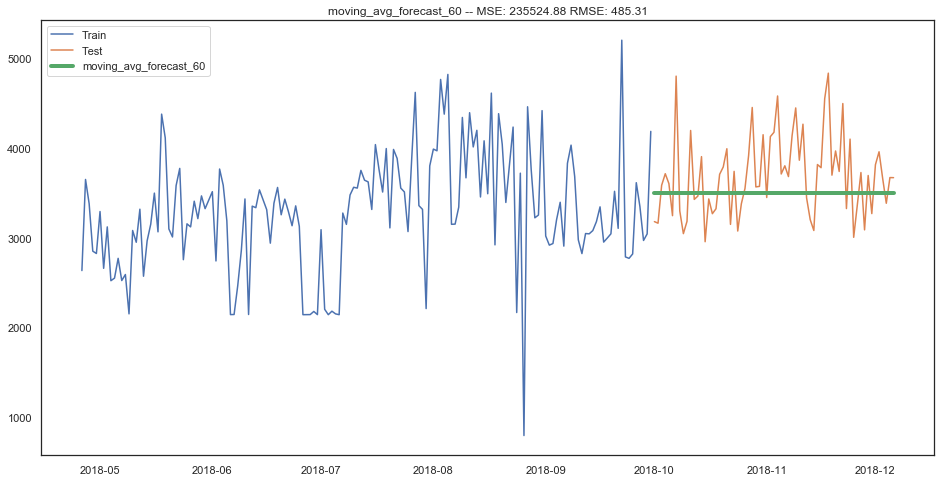

In [70]:
yhat['moving_avg_forecast_60'] = train.rolling(60).mean().iloc[-1]

plot_and_eval(yhat.moving_avg_forecast_60)

In [65]:
period_vals = [1, 4]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean()
    print(yhat[f'moving_avg_forecast_{periods}'])
    
forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

# plot_and_eval(forecasts, linewidth=2)

index
2018-10-01   NaN
2018-10-02   NaN
2018-10-03   NaN
2018-10-04   NaN
2018-10-05   NaN
2018-10-06   NaN
2018-10-07   NaN
2018-10-08   NaN
2018-10-09   NaN
2018-10-10   NaN
2018-10-11   NaN
2018-10-12   NaN
2018-10-13   NaN
2018-10-14   NaN
2018-10-15   NaN
2018-10-16   NaN
2018-10-17   NaN
2018-10-18   NaN
2018-10-19   NaN
2018-10-20   NaN
2018-10-21   NaN
2018-10-22   NaN
2018-10-23   NaN
2018-10-24   NaN
2018-10-25   NaN
2018-10-26   NaN
2018-10-27   NaN
2018-10-28   NaN
2018-10-29   NaN
2018-10-30   NaN
              ..
2018-11-07   NaN
2018-11-08   NaN
2018-11-09   NaN
2018-11-10   NaN
2018-11-11   NaN
2018-11-12   NaN
2018-11-13   NaN
2018-11-14   NaN
2018-11-15   NaN
2018-11-16   NaN
2018-11-17   NaN
2018-11-18   NaN
2018-11-19   NaN
2018-11-20   NaN
2018-11-21   NaN
2018-11-22   NaN
2018-11-23   NaN
2018-11-24   NaN
2018-11-25   NaN
2018-11-26   NaN
2018-11-27   NaN
2018-11-28   NaN
2018-11-29   NaN
2018-11-30   NaN
2018-12-01   NaN
2018-12-02   NaN
2018-12-03   NaN
2018-12-

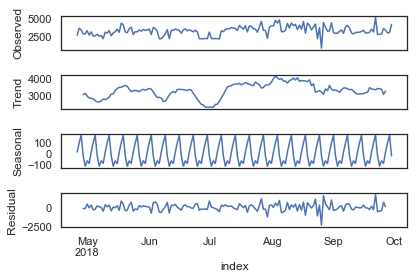

In [71]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

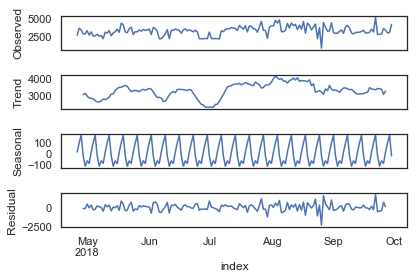

In [72]:
# train = df['2018-04':'2018-09'].total_calories.resample('D').agg('mean')
# test = df['2018-10':'2018-12'].total_calories.resample('D').agg('mean')

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

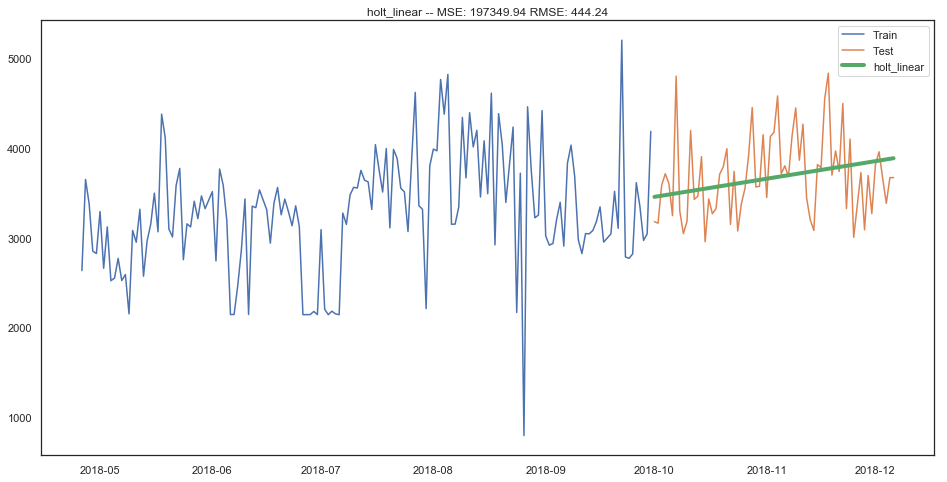

In [89]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.05)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

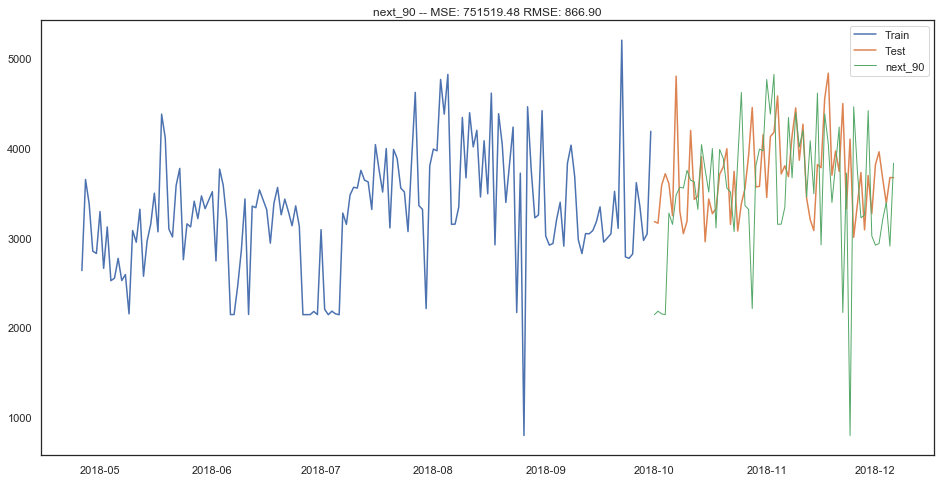

In [132]:
using_last_quarter = train['2018-07':'2018-09']\
    .reset_index()\
    .drop(columns='index')\
    .set_index(train['2018-07':'2018-09'].index+90)
yhat['next_90'] = using_last_quarter
plot_and_eval(yhat.next_90, linewidth=1)

In [145]:
train

index
2018-04-26    2635.0
2018-04-27    3649.0
2018-04-28    3379.0
2018-04-29    2851.0
2018-04-30    2825.0
2018-05-01    3292.0
2018-05-02    2660.0
2018-05-03    3121.0
2018-05-04    2522.0
2018-05-05    2551.0
2018-05-06    2771.0
2018-05-07    2524.0
2018-05-08    2591.0
2018-05-09    2153.0
2018-05-10    3081.0
2018-05-11    2950.0
2018-05-12    3318.0
2018-05-13    2572.0
2018-05-14    2966.0
2018-05-15    3152.0
2018-05-16    3497.0
2018-05-17    3066.0
2018-05-18    4376.0
2018-05-19    4112.0
2018-05-20    3098.0
2018-05-21    3009.0
2018-05-22    3581.0
2018-05-23    3772.0
2018-05-24    2756.0
2018-05-25    3155.0
               ...  
2018-09-01    3020.0
2018-09-02    2918.0
2018-09-03    2936.0
2018-09-04    3201.0
2018-09-05    3395.0
2018-09-06    2907.0
2018-09-07    3829.0
2018-09-08    4031.0
2018-09-09    3682.0
2018-09-10    2977.0
2018-09-11    2824.0
2018-09-12    3047.0
2018-09-13    3044.0
2018-09-14    3080.0
2018-09-15    3180.0
2018-09-16    3344.0
2018-09

92
index
2018-07-01    3559.941176
2018-07-02    2673.941176
Freq: D, Name: total_calories, dtype: float64
index
2018-09-29    3512.941176
2018-09-30    4653.941176
Freq: D, Name: total_calories, dtype: float64
index
2018-07-01    3559.941176
2018-07-02    2673.941176
Freq: D, Name: total_calories, dtype: float64
index
2018-09-29    3512.941176
2018-09-30    4653.941176
Freq: D, Name: total_calories, dtype: float64


ValueError: Found input variables with inconsistent numbers of samples: [67, 91]

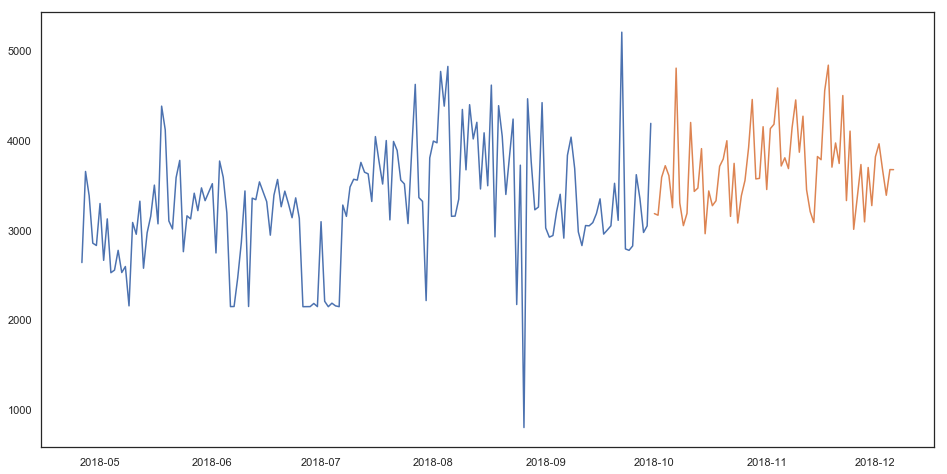

In [170]:
predictions = train['2018-07':'2018-09'] + train.diff(90).mean()
print(len(predictions))
print(predictions[:2])
print(predictions[-2:])
# predictions.index = pd.date_range('20180701', periods=92)
print(predictions[:2])
print(predictions[-2:])
predictions = predictions[:-1]
predictions.name = 'Last 90 Days + Mean'

plot_and_eval(predictions, linewidth=1)

# Prophet

In [171]:
df.columns

Index(['activity_calories', 'distance', 'floors', 'mins_active_high',
       'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps',
       'total_calories'],
      dtype='object')

In [172]:
import seaborn as sns
from fbprophet import Prophet

In [185]:
df.reset_index(inplace=True)
df.head()

,level_0,index,activity_calories,distance,floors,mins_active_high,mins_active_light,mins_active_med,mins_sedentary,steps,total_calories
0,0,2018-04-26,566.0,1.38,2.0,0.0,93.0,0.0,1347.0,2931.0,2635.0
1,1,2018-04-27,1752.0,4.70,19.0,17.0,219.0,46.0,1158.0,9971.0,3649.0
2,2,2018-04-28,1124.0,1.66,2.0,11.0,155.0,22.0,702.0,3521.0,3379.0
3,3,2018-04-29,602.0,0.77,0.0,0.0,122.0,0.0,891.0,1639.0,2851.0
4,4,2018-04-30,540.0,0.62,0.0,0.0,104.0,0.0,880.0,1323.0,2825.0


In [255]:
d_df = pd.DataFrame()
d_df

""


In [256]:
d_df['y'] = df.distance
d_df['ds'] = pd.to_datetime(df['index'])

d_df = d_df.groupby(['ds'])['y'].sum().reset_index()

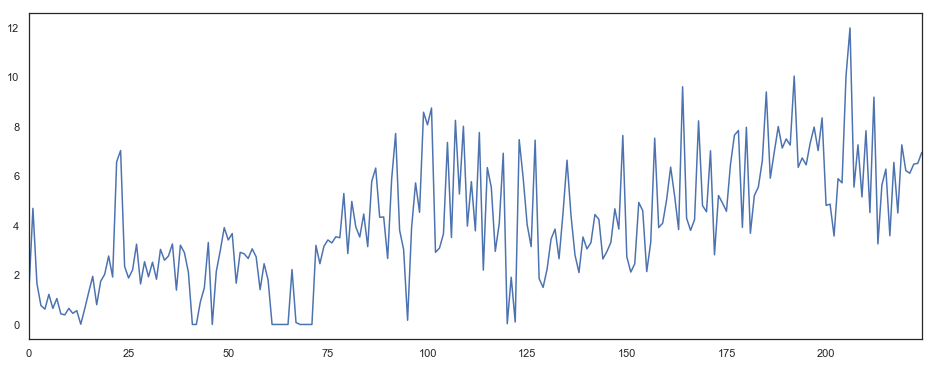

In [257]:
plt.figure(figsize=(16,6))
sns.tsplot(d_df.y)

In [258]:
d_df.head()

,ds,y
0,2018-04-26,1.38
1,2018-04-27,4.70
2,2018-04-28,1.66
3,2018-04-29,0.77
4,2018-04-30,0.62


In [260]:
d_df['cap'] = 11
d_df['floor'] = 1

m = Prophet(daily_seasonality=True, growth='logistic',changepoint_range=0.9)
m.fit(d_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [261]:
future = m.make_future_dataframe(periods=92)
future['cap'] = 11
future['floor'] = 1
print(future.head())
print(future.tail())
print(d_df.tail())

          ds  cap  floor
0 2018-04-26   11      1
1 2018-04-27   11      1
2 2018-04-28   11      1
3 2018-04-29   11      1
4 2018-04-30   11      1
            ds  cap  floor
312 2019-03-04   11      1
313 2019-03-05   11      1
314 2019-03-06   11      1
315 2019-03-07   11      1
316 2019-03-08   11      1
            ds     y  cap  floor
220 2018-12-02  6.23   11      1
221 2018-12-03  6.12   11      1
222 2018-12-04  6.49   11      1
223 2018-12-05  6.52   11      1
224 2018-12-06  6.96   11      1


In [262]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
312,2019-03-04,9.624572,7.150818,12.058851
313,2019-03-05,9.877969,7.665886,12.163728
314,2019-03-06,9.754186,7.240392,12.225945
315,2019-03-07,10.376313,7.935101,12.791398
316,2019-03-08,10.500458,8.117393,12.835066


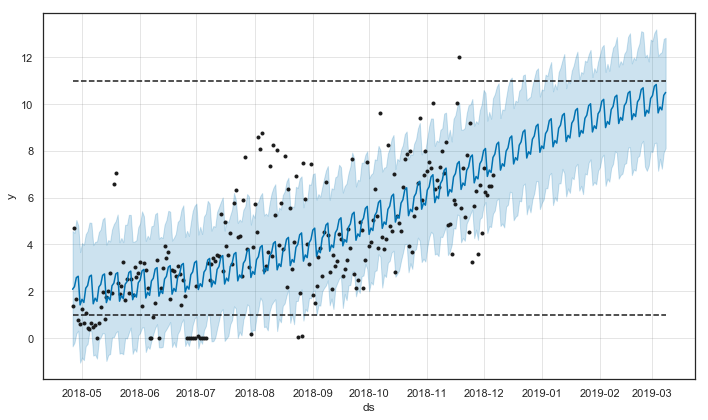

In [263]:
fig1 = m.plot(forecast)

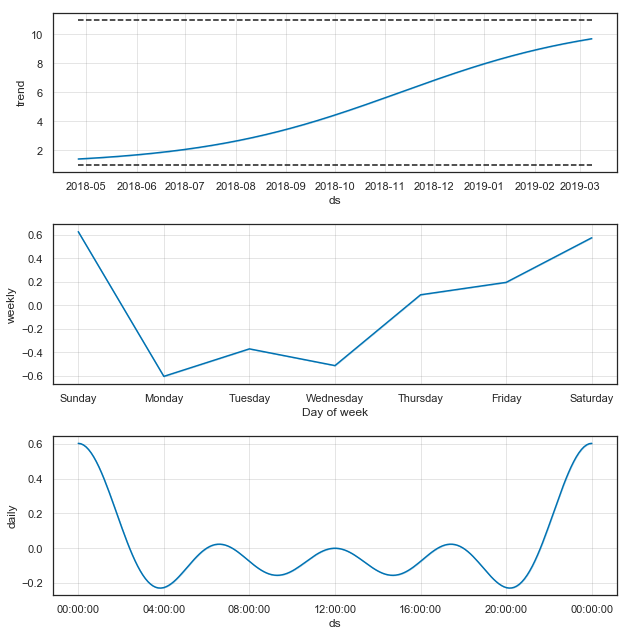

In [264]:
fig2 = m.plot_components(forecast)

In [265]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='30 days')


df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00


In [266]:
df_p.sort_values(by='rmse', ascending=True)

,horizon,mse,rmse,mae,mape,coverage
65,6 days,3.581367,1.892450,1.527604,0.362360,0.809524
5,6 days,3.633904,1.906280,1.558469,0.358184,0.809524
6,7 days,3.879499,1.969644,1.575260,0.348232,0.857143
155,6 days,3.897200,1.974133,1.595216,0.359513,0.761905
125,6 days,4.060560,2.015083,1.663739,0.364955,0.761905
35,6 days,4.073203,2.018218,1.666632,0.380001,0.761905
95,6 days,4.121541,2.030158,1.627612,0.398599,0.809524
66,7 days,4.182728,2.045172,1.666563,0.379902,0.857143
185,6 days,4.211943,2.052302,1.720503,0.377290,0.761905
164,15 days,4.270616,2.066547,1.705342,0.410523,0.714286


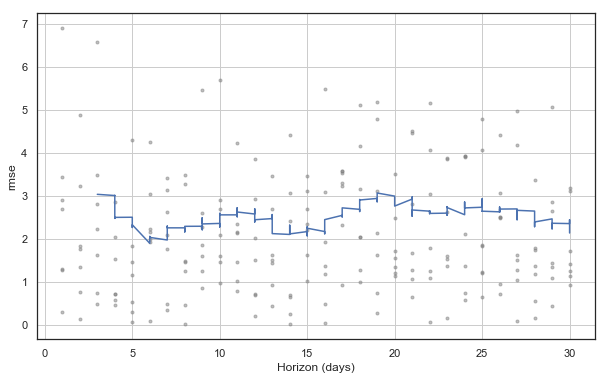

In [267]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

In [283]:
df.rename(columns={'index':'date'}, inplace=True)
df[['date']].head()

,date
0,2018-04-26
1,2018-04-27
2,2018-04-28
3,2018-04-29
4,2018-04-30


In [284]:
from datetime import timedelta, datetime
import itertools

In [285]:
# - Write a function to parse a date column into 6 additional 
# columns (while keeping the original date): year, quarter, month, day of month, day of week, weekend vs. weekday
def add_date_parts(df):
    df = df.copy()
    df['year'] = df.date.dt.year
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['hour'] = df.date.dt.hour
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekday'] = df.date.dt.day_name().str[:3]
    # df['weekday'] = df.date.dt.day_name().str[:3]
    df['is_weekend'] = ((pd.DatetimeIndex(df.date).dayofweek) // 5 == 1)
    return df.set_index('date')


# - Create a new dataframe that aggregates the sales_total and 
# sale_amount(item count) using sum and median by day of week.
def aggregate_by_weekday(df):
    df = df.copy()
    by_dayofweek = pd.DataFrame()
    by_dayofweek['quantity_sum'] = df.groupby(['weekday']).quantity.sum()
    by_dayofweek['item_cnt_sum'] = df.groupby(['weekday']).sale_total.sum()
    by_dayofweek['quantity_median'] = df.groupby(['weekday']).quantity.median()
    by_dayofweek['item_cnt_median'] = df.groupby(['weekday']).sale_total.median()
    return by_dayofweek

In [286]:
df = add_date_parts(df)

In [287]:
df.head()

,level_0,activity_calories,distance,floors,mins_active_high,mins_active_light,mins_active_med,mins_sedentary,steps,total_calories,year,quarter,month,day,hour,dayofweek,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,
2018-04-26,0,566.0,1.38,2.0,0.0,93.0,0.0,1347.0,2931.0,2635.0,2018,2,4,26,0,3,Thu,False
2018-04-27,1,1752.0,4.70,19.0,17.0,219.0,46.0,1158.0,9971.0,3649.0,2018,2,4,27,0,4,Fri,False
2018-04-28,2,1124.0,1.66,2.0,11.0,155.0,22.0,702.0,3521.0,3379.0,2018,2,4,28,0,5,Sat,True
2018-04-29,3,602.0,0.77,0.0,0.0,122.0,0.0,891.0,1639.0,2851.0,2018,2,4,29,0,6,Sun,True
2018-04-30,4,540.0,0.62,0.0,0.0,104.0,0.0,880.0,1323.0,2825.0,2018,2,4,30,0,0,Mon,False
